In [ ]:
import mne
import logging
import yasa


ModuleNotFoundError: No module named 'yasa'

In [ ]:
mne_logger = logging.getLogger('mne')
mne_logger.setLevel(logging.CRITICAL)

In [ ]:
data_path = "dataset"
_asset = "name_to_target.csv"

In [ ]:
import pandas as pd

df = pd.read_csv(_asset)
df.head()

,name,path_file,burnout_Boiko,exhaustion,exhaustion_class,Active_phase
0,azo,C:\Users\Administrator\Downloads\EEG_DATA\EEG_...,135.0,33.0,Active Phase,Active Phase
1,ale,C:\Users\Administrator\Downloads\EEG_DATA\EEG_...,64.0,17.0,Not Diagnosed,Not Diagnosed
2,andri,C:\Users\Administrator\Downloads\EEG_DATA\EEG_...,209.0,87.0,Mental Issue,Active Phase
3,andru,C:\Users\Administrator\Downloads\EEG_DATA\EEG_...,126.0,40.0,Active Phase,Active Phase
4,bas,C:\Users\Administrator\Downloads\EEG_DATA\EEG_...,103.0,34.0,Active Phase,Active Phase


In [ ]:
mapping = dict(zip(df['name'],df['exhaustion_class']))

for name,label in mapping.items():
    print(name,label)
    break

azo Active Phase


## Image generation

In [ ]:
import numpy as np
AZ_PROJ_VALUE = np.array([
    [-0.0309026, 0.11458518],
    [0.02840949, 0.11534631],
    [-0.05180905, 0.0866879],
    [0.05027427, 0.08743839],
    [-0.07187663, 0.07310353],
    [0.07143526, 0.07450512],
    [-0.08598209, 0.01487164],
    [0.08326136, 0.01525818],
    [-0.06714873, 0.02335823],
    [0.06532887, 0.0235731],
    [-0.07445797, -0.04212316],
    [0.07103246, -0.04225998],
    [-0.05503824, -0.0442103],
    [0.05363601, -0.04433453],
    [-0.03157357, -0.08056835],
    [0.02768309, -0.08048884],
    [-0.00122928, 0.09327445],
    [-0.00137414, 0.02761709],
    [-0.00170945, -0.04521299]
])
IMG_RESOLUTION = 64

In [ ]:
from sklearn.preprocessing import scale
from scipy.interpolate import griddata
def augment_EEG(features, std_mult, pca=False, n_components=2):
    # Placeholder for EEG data augmentation logic.
    # Implement augmentation based on PCA or noise addition as required.
    pass

def gen_images(features,locs=AZ_PROJ_VALUE, n_gridpoints = IMG_RESOLUTION, normalize=True,
               augment=False, pca=False, std_mult=0.1, n_components=2, edgeless=False):
    """
    Generates EEG images given electrode locations in 2D space and multiple feature values for each electrode

    :param locs: An array with shape [n_electrodes, 2] containing X, Y
                        coordinates for each electrode.
    :param features: Feature matrix as [n_samples, n_features]
                                Features are as columns.
                                Features corresponding to each frequency band are concatenated.
                                (alpha1, alpha2, ..., beta1, beta2,...)
    :param n_gridpoints: Number of pixels in the output images
    :param normalize:   Flag for whether to normalize each band over all samples
    :param augment:     Flag for generating augmented images
    :param pca:         Flag for PCA based data augmentation
    :param std_mult     Multiplier for std of added noise
    :param n_components: Number of components in PCA to retain for augmentation
    :param edgeless:    If True generates edgeless images by adding artificial channels
                        at four corners of the image with value = 0 (default=False).
    :return:            Tensor of size [samples, colors, W, H] containing generated
                        images.
    """
    feat_array_temp = []
    nElectrodes = locs.shape[0]  # Number of electrodes
    # Test whether the feature vector length is divisible by number of electrodes
    assert features.shape[1] % nElectrodes == 0
    n_colors = features.shape[1] // nElectrodes
    for c in range(int(n_colors)):
        feat_array_temp.append(features[:, c * nElectrodes: nElectrodes * (c + 1)])

    nSamples = features.shape[0]
    # Interpolate the values
    grid_x, grid_y = np.mgrid[
                     min(locs[:, 0]):max(locs[:, 0]):n_gridpoints * 1j,
                     min(locs[:, 1]):max(locs[:, 1]):n_gridpoints * 1j
                     ]
    temp_interp = []
    for c in range(n_colors):
        temp_interp.append(np.zeros([nSamples, n_gridpoints, n_gridpoints]))
    # Generate edgeless images
    if edgeless:
        min_x, min_y = np.min(locs, axis=0)
        max_x, max_y = np.max(locs, axis=0)
        locs = np.append(locs, np.array([[min_x, min_y], [min_x, max_y], [max_x, min_y], [max_x, max_y]]), axis=0)
        for c in range(n_colors):
            feat_array_temp[c] = np.append(feat_array_temp[c], np.zeros((nSamples, 4)), axis=1)
    # Interpolating
    for i in range(nSamples):
        for c in range(n_colors):
            temp_interp[c][i, :, :] = griddata(locs, feat_array_temp[c][i, :], (grid_x, grid_y),
                                               method='cubic', fill_value=np.nan)
        print('Interpolating {0}/{1}\r'.format(i + 1, nSamples), end='\r')
    # Normalizing
    for c in range(n_colors):
        if normalize:
            temp_interp[c][~np.isnan(temp_interp[c])] = \
                scale(temp_interp[c][~np.isnan(temp_interp[c])])
        temp_interp[c] = np.nan_to_num(temp_interp[c])
    return np.swapaxes(np.asarray(temp_interp), 0, 1)  # swap axes to have [samples, colors, W, H]



# Cnn-1 data generator

In [ ]:
from joblib import Parallel, delayed
import os
import numpy as np
import mne
import pandas as pd
from datetime import datetime

def process_dataset(name, dataset_dir, output_directory, map_dict, sfreq=500):
    data_path = os.path.join(dataset_dir, f"{name}.fif")
    raw = mne.io.read_raw_fif(data_path, preload=True)
    freqs = (50, 100, 150)
    raw.notch_filter(freqs=freqs, method='spectrum_fit', n_jobs=1)
    raw.filter(l_freq=0.5, h_freq=None)  # High-pass
    raw.filter(l_freq=None, h_freq=45.0)  # Low-pass
    raw.filter(l_freq=1.0, h_freq=40.0)  # Band-pass
    raw_eeg = raw.pick_types(meg=False, eeg=True)
    epochs = mne.make_fixed_length_epochs(raw_eeg, duration=20.0, overlap=18.0, proj=True)

    labels = {}
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")  # Get current date and time
    for epoch_index, epoch in enumerate(epochs):
        epoch_features = [yasa.bandpower(np.array([ch_data]), sf=sfreq)[['Alpha', 'Beta', 'Theta']].values.flatten()
                          for ch_data in epoch]
        features = np.array(epoch_features).reshape(1, -1)  # Adjust shape based on your gen_images function
        img = gen_images(features)
        img = img.transpose((0, 3, 2, 1))
        unique_identifier = f"{name}_img{epoch_index}_{current_time}"
        _path = os.path.join(output_directory, f"{unique_identifier}.npy")
        np.save(_path, img[0])
        labels[unique_identifier] = map_dict[name]

    return labels

In [ ]:
data_path = "C:\\Users\\Administrator\\Downloads\\dataset"# Here put the path of the dataset, the raw data barely preprocessed. I already provide the code in the first notebook
out_dir = "C:\\Users\\Administrator\\Downloads\\cnn_2_data"# put here the output data namely where the function gonna store the processed data
# Parallel execution and collecting labels
all_labels = Parallel(n_jobs=-1)(delayed(process_dataset)(name, data_path, out_dir, mapping, sfreq=500) for name in mapping.keys())

# Flatten the list of dictionaries into a single dictionary
final_labels = {k: v for d in all_labels for k, v in d.items()}

# Convert dictionary to DataFrame and save as CSV
label_df = pd.DataFrame(list(final_labels.items()), columns=['Image', 'Label'])
label_df.to_csv('cnn2_labels.csv', index=False)

print("Labels saved to cnn2_labels.csv")

Labels saved to cnn2_labels.csv


In [ ]:
pth_1 = os.path.join(out_dir,"zle_img60_20240419_040042.npy")
pth_2 = os.path.join(out_dir,"zle_img0_20240419_040042.npy")
im1 = np.load(pth_1)
im2 = np.load(pth_2)

19-Apr-24 04:39:10 | WARNING | Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


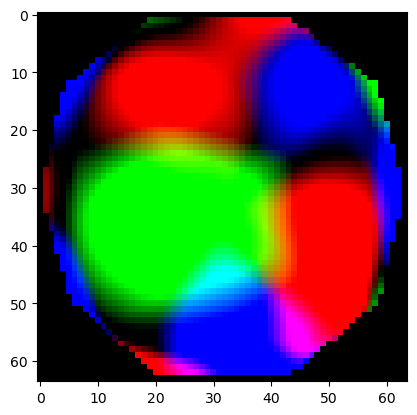

19-Apr-24 04:39:10 | WARNING | Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


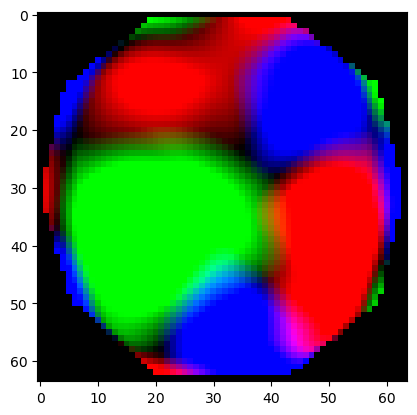

In [ ]:
plot_image(im1)
plot_image(im2)